In [1]:
import os
import torch
import torchaudio
import kagglehub
from torch.utils.data import Dataset, DataLoader


path = kagglehub.dataset_download('sayuksh/denoising-audio-collection')

def get_all_wav_files(folder):
    """Recursively list all .wav files in a folder and its subfolders"""
    wav_files = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.endswith('.wav'):
                wav_files.append(os.path.join(root, f))
    return sorted(wav_files)


100%|██████████| 15.3G/15.3G [02:58<00:00, 92.0MB/s]

Extracting files...


In [2]:
import torch.nn.functional as F

TARGET_LENGTH = 32000

def pad_or_crop(waveform, target_length=TARGET_LENGTH):
    length = waveform.size(1)
    if length < target_length:
        pad = target_length - length
        waveform = F.pad(waveform, (0, pad))
    else:
        waveform = waveform[:, :target_length]
    return waveform


In [3]:
import torchaudio.transforms as T

class DenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, target_sr=16000, transform=None):
        self.noisy_files = get_all_wav_files(noisy_dir)
        self.clean_files = get_all_wav_files(clean_dir)
        self.target_sr = target_sr
        self.transform = transform
        self.resamplers = {}  # cache resamplers if needed

    def __len__(self):
        return len(self.noisy_files)

    def __getitem__(self, idx):
        noisy_waveform, sr1 = torchaudio.load(self.noisy_files[idx])
        clean_waveform, sr2 = torchaudio.load(self.clean_files[idx])
        assert sr1 == sr2, "Sample rate mismatch"

        # Resample if needed
        if sr1 != self.target_sr:
            resampler = T.Resample(orig_freq=sr1, new_freq=self.target_sr)
            noisy_waveform = resampler(noisy_waveform)
            clean_waveform = resampler(clean_waveform)

        # Optional: pad or crop
        noisy_waveform = pad_or_crop(noisy_waveform, target_length=self.target_sr * 2)
        clean_waveform = pad_or_crop(clean_waveform, target_length=self.target_sr * 2)

        if self.transform:
            noisy_waveform = self.transform(noisy_waveform)
            clean_waveform = self.transform(clean_waveform)

        return noisy_waveform, clean_waveform


In [4]:
NOISYDIR = os.path.join(path, 'noisy_trainset_28spk_wav')
CLEANDIR = os.path.join(path, 'clean_trainset_28spk_wav')

In [5]:
print(NOISYDIR)

/root/.cache/kagglehub/datasets/sayuksh/denoising-audio-collection/versions/1/noisy_trainset_28spk_wav


In [6]:
!pip install torchcodec
dataset = DenoisingDataset(
    noisy_dir=NOISYDIR,
    clean_dir=CLEANDIR
)

loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Test batch
for noisy, clean in loader:
    print("Noisy shape:", noisy.shape)
    print("Clean shape:", clean.shape)
    break

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.9 MB/s eta 0:00:00
Noisy shape: torch.Size([10, 1, 32000])
Clean shape: torch.Size([10, 1, 32000])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv1dBlock(nn.Module):
    """Two 1D conv layers with ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNet1D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=16):
        super().__init__()

        # Encoder
        self.enc1 = Conv1dBlock(in_channels, base_channels)
        self.enc2 = Conv1dBlock(base_channels, base_channels*2)
        self.enc3 = Conv1dBlock(base_channels*2, base_channels*4)

        # Downsampling convs
        self.down1 = nn.Conv1d(base_channels, base_channels, kernel_size=4, stride=2, padding=1)
        self.down2 = nn.Conv1d(base_channels*2, base_channels*2, kernel_size=4, stride=2, padding=1)
        self.down3 = nn.Conv1d(base_channels*4, base_channels*4, kernel_size=4, stride=2, padding=1)

        # Bottleneck
        self.bottleneck = Conv1dBlock(base_channels*4, base_channels*8)

        # Decoder
        self.up3 = nn.ConvTranspose1d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1)
        self.dec3 = Conv1dBlock(base_channels*8, base_channels*4)

        self.up2 = nn.ConvTranspose1d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1)
        self.dec2 = Conv1dBlock(base_channels*4, base_channels*2)

        self.up1 = nn.ConvTranspose1d(base_channels*2, base_channels, kernel_size=4, stride=2, padding=1)
        self.dec1 = Conv1dBlock(base_channels*2, base_channels)

        # Final output
        self.final = nn.Conv1d(base_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        x = self.down1(e1)

        e2 = self.enc2(x)
        x = self.down2(e2)

        e3 = self.enc3(x)
        x = self.down3(e3)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder with skip connections
        x = self.up3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1(x)

        # Final output
        out = self.final(x)
        return out



In [13]:
# Assume you have DataLoader 'loader' with (noisy, clean) batches

model = UNet1D()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.MSELoss()
loss = []
num_steps = 10

for epoch in range(1):

    for noisy, clean in loader:
        num_steps -= 1
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output, clean)
        loss.backward()
        optimizer.step()
        print("Batch loss:", loss.item())
        if num_steps == 0:
          break


Batch loss: 0.029871033504605293
Batch loss: 0.019129274412989616
Batch loss: 0.032248154282569885
Batch loss: 0.00846275594085455
Batch loss: 0.010162734426558018
Batch loss: 0.010942899622023106
Batch loss: 0.009992926381528378
Batch loss: 0.008035661652684212
Batch loss: 0.006100778002291918
Batch loss: 0.004601913969963789


In [14]:
import matplotlib.pyplot as plt
from IPython.display import Audio


def load_and_preprocess(wav_path, target_sr=16000, target_length=32000):
    waveform, sr = torchaudio.load(wav_path)
    if sr != target_sr:
        resampler = T.Resample(orig_freq=sr, new_freq=target_sr)
        waveform = resampler(waveform)
    waveform = pad_or_crop(waveform, target_length)
    return waveform.unsqueeze(0)  # add batch dim

# --- Load a noisy example ---
noisy_wav_path = os.path.join(NOISYDIR, 'noisy_trainset_28spk_wav/p226_002.wav')
clean_wav_path = os.path.join(CLEANDIR, 'clean_trainset_28spk_wav/p226_002.wav')
noisy_waveform = load_and_preprocess(noisy_wav_path)
clean_waveform = load_and_preprocess(clean_wav_path)
# --- Load your trained model ---
# Assuming 'model' is already trained and on device
model.eval()
with torch.no_grad():
    denoised_waveform = model(noisy_waveform)

print(loss)
# --- Convert back to CPU and remove batch dim ---
noisy_waveform_cpu = noisy_waveform.squeeze(0).cpu()
denoised_waveform_cpu = denoised_waveform.squeeze(0).cpu()
clean_waveform_cpu = clean_waveform.squeeze(0).cpu()

# --- Play audio in Colab ---
print("Noisy audio:")
Audio(noisy_waveform_cpu.numpy()[0], rate=16000)




tensor(0.0046, grad_fn=<MseLossBackward0>)
Noisy audio:


In [15]:
print("Denoised audio:")
Audio(denoised_waveform_cpu.numpy()[0], rate=16000)



Denoised audio:


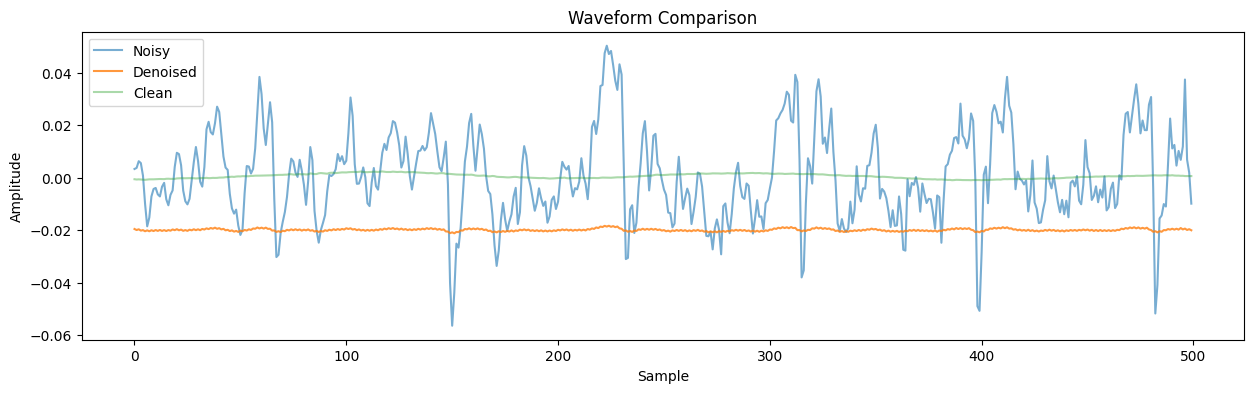

In [16]:
# --- Optional: plot waveforms ---
plt.figure(figsize=(15,4))
plt.plot(noisy_waveform_cpu.numpy()[0][8000:8500], label='Noisy', alpha=0.6)
plt.plot(denoised_waveform_cpu.numpy()[0][8000:8500], label='Denoised', alpha=0.8)
plt.plot(clean_waveform_cpu.numpy()[0][8000:8500], label='Clean', alpha=0.4)
plt.legend()
plt.title("Waveform Comparison")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_fft(waveforms, labels, sr=48000, n_fft=4096):
    """
    waveforms: list of 1D numpy arrays
    labels:    list of strings
    sr:        sample rate
    n_fft:     FFT window
    """
    plt.figure(figsize=(15,4))

    for waveform, label in zip(waveforms, labels):
        # Compute FFT
        fft_vals = np.fft.rfft(waveform, n=n_fft)

        # Magnitude spectrum
        mag = np.abs(fft_vals)

        # Frequency axis
        freqs = np.fft.rfftfreq(n_fft, 1/sr)

        plt.plot(freqs, mag, label=label, alpha=0.8)

    plt.title("Fourier-Domain Magnitude Spectrum")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, 3000)  # speech band (optional)
    plt.show()



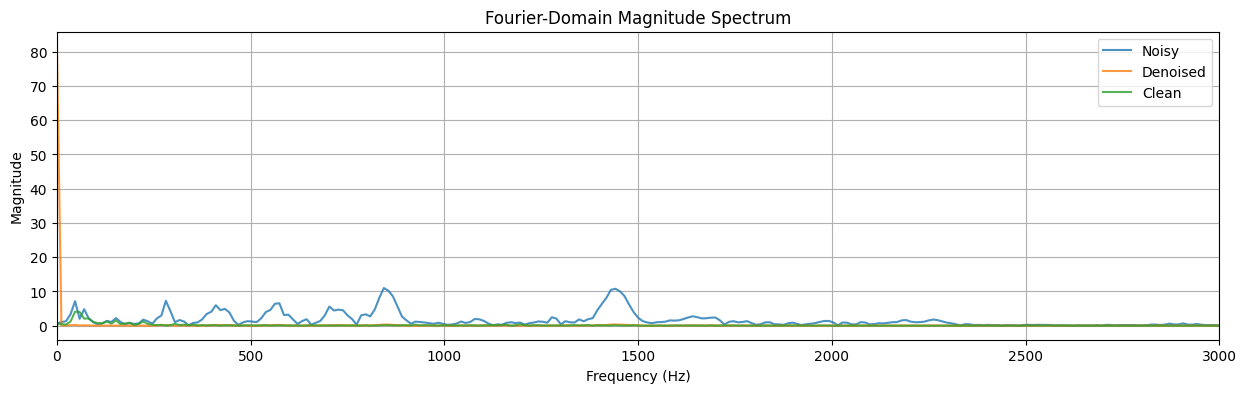

In [18]:
noisy_wav = noisy_waveform_cpu.numpy()[0]
denoised_wav = denoised_waveform_cpu.numpy()[0]
clean_wav = clean_waveform_cpu.numpy()[0]

plot_fft(
    [noisy_wav, denoised_wav, clean_wav],
    ["Noisy", "Denoised", "Clean"],
    sr=48000  # your dataset sample rate
)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Conv1dBlock(nn.Module):
    """Two 1D conv layers with ReLU"""
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class UNet1D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=16):
        super().__init__()

        # Encoder
        self.enc1 = Conv1dBlock(in_channels, base_channels)
        self.enc2 = Conv1dBlock(base_channels, base_channels*2)
        self.enc3 = Conv1dBlock(base_channels*2, base_channels*4)

        # Downsampling convs
        self.down1 = nn.Conv1d(base_channels, base_channels, kernel_size=4, stride=2, padding=1)
        self.down2 = nn.Conv1d(base_channels*2, base_channels*2, kernel_size=4, stride=2, padding=1)
        self.down3 = nn.Conv1d(base_channels*4, base_channels*4, kernel_size=4, stride=2, padding=1)

        # Bottleneck
        self.bottleneck = Conv1dBlock(base_channels*4, base_channels*8)

        # Decoder
        self.up3 = nn.ConvTranspose1d(base_channels*8, base_channels*4, kernel_size=4, stride=2, padding=1)
        self.dec3 = Conv1dBlock(base_channels*8, base_channels*4)

        self.up2 = nn.ConvTranspose1d(base_channels*4, base_channels*2, kernel_size=4, stride=2, padding=1)
        self.dec2 = Conv1dBlock(base_channels*4, base_channels*2)

        self.up1 = nn.ConvTranspose1d(base_channels*2, base_channels, kernel_size=4, stride=2, padding=1)
        self.dec1 = Conv1dBlock(base_channels*2, base_channels)

        # Final output
        self.final = nn.Conv1d(base_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        x = self.down1(e1)

        e2 = self.enc2(x)
        x = self.down2(e2)

        e3 = self.enc3(x)
        x = self.down3(e3)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder with skip connections
        x = self.up3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3(x)

        x = self.up2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2(x)

        x = self.up1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1(x)

        # Final output
        out = self.final(x)
        return out



In [ ]:
!pip install torchsummary
from torchsummary import summary

model = UNet1D()
summary(model, input_size=(1, 32000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1            [-1, 16, 32000]              64
              ReLU-2            [-1, 16, 32000]               0
            Conv1d-3            [-1, 16, 32000]             784
              ReLU-4            [-1, 16, 32000]               0
       Conv1dBlock-5            [-1, 16, 32000]               0
            Conv1d-6            [-1, 16, 16000]           1,040
            Conv1d-7            [-1, 32, 16000]           1,568
              ReLU-8            [-1, 32, 16000]               0
            Conv1d-9            [-1, 32, 16000]           3,104
             ReLU-10            [-1, 32, 16000]               0
      Conv1dBlock-11            [-1, 32, 16000]               0
           Conv1d-12             [-1, 32, 8000]           4,128
           Conv1d-13             [-1, 64, 8000]           6,208
             ReLU-14             [-1, 6

In [ ]:
!pip install torchinfo
from torchinfo import summaryz

summary(model, input_size=(1, 1, 32000), col_names=["input_size", "output_size", "num_params"])


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet1D                                   [1, 1, 32000]             [1, 1, 32000]             --
├─Conv1dBlock: 1-1                       [1, 1, 32000]             [1, 16, 32000]            --
│    └─Conv1d: 2-1                       [1, 1, 32000]             [1, 16, 32000]            64
│    └─ReLU: 2-2                         [1, 16, 32000]            [1, 16, 32000]            --
│    └─Conv1d: 2-3                       [1, 16, 32000]            [1, 16, 32000]            784
│    └─ReLU: 2-4                         [1, 16, 32000]            [1, 16, 32000]            --
├─Conv1d: 1-2                            [1, 16, 32000]            [1, 16, 16000]            1,040
├─Conv1dBlock: 1-3                       [1, 16, 16000]            [1, 32, 16000]            --
│    └─Conv1d: 2-5                       [1, 16, 16000]            [1, 32, 16000]            1,568
│    └─ReLU: 2-6            

In [23]:
import numpy as np
from scipy.io import wavfile
from transformers import pipeline

wavfile.write("noisy.wav", 16000, noisy_wav)
wavfile.write("denoised.wav", 16000, denoised_wav)


pipe = pipeline(
    task="automatic-speech-recognition",
    model="openai/whisper-small"
)

noisy_result = pipe("noisy.wav")
print(noisy_result["text"])

denoised_result = pipe("denoised.wav")
print(denoised_result["text"])




/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

Device set to use cpu
`return_token_timestamps` is deprecated for WhisperFeatureExtractor and will be removed in Transformers v5. Use `return_attention_mask` instead, as the number of frames can be inferred from it.
Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.


 Ask her to bring these things
 Ask her to bring these things.
